In [29]:
print('hello')

hello


In [66]:
#Creating a database for the pensioners

#Import needed packages

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

#ensure reproducibility
random.seed(1)
np.random.seed(1)

#number of pensioners :
num_pens = 100

#We need to create empty lists for each characteristic of each pensioners
pens_id = []
pens_sex = []
pens_bdate = []
pens_amount = []

#fixed initial date

initial_date = datetime(2024, 1, 1)

#loop num_pens times to create the data base

for i in range(1, num_pens+1):
    #ID
    pens_id.append(i)
    #Sex
    sex = random.choice(["Male","Female"])
    pens_sex.append(sex)
    #Birth date
    age = int(random.triangular(65, 100, 75)) #mode at 75 to have less people towards 90-100yo
    bdate = initial_date - timedelta(days=365*age + random.randint(0,365))
    pens_bdate.append(bdate.strftime("%Y-%m-%d"))
    #Pension Amount (see the last cell for how I got this distribution)
    if sex == "Male":
        pension_amount = np.random.lognormal(mean=10.748, sigma=0.5)
    else :
        pension_amount = np.random.lognormal(mean=10.35, sigma=0.5)
    pens_amount.append(pension_amount)

    
#create a DataFrame
pensioners_df = pd.DataFrame({
    'ID': pens_id,
    'Sex': pens_sex,
    'Birth Date': pens_bdate,
    'Pension Amount': pens_amount
})

#convert 'Birth Date' column to datetime
pensioners_df['Birth Date'] = pd.to_datetime(pensioners_df['Birth Date'])
#round the 'Pension Amount' column to two decimals (basically cents)
pensioners_df['Pension Amount'] = pensioners_df['Pension Amount'].round(2)


#print the first 10 rows to check
print(pensioners_df.head(100))
print(pensioners_df.dtypes)


     ID     Sex Birth Date  Pension Amount
0     1    Male 1943-12-20       104838.12
1     2  Female 1952-06-02        23020.07
2     3  Female 1941-10-06        24002.52
3     4    Male 1945-07-05        27214.79
4     5  Female 1943-01-20        48180.22
5     6  Female 1949-09-24         9889.52
6     7    Male 1934-01-08       111346.91
7     8    Male 1956-04-15        31805.56
8     9    Male 1931-07-13        54585.28
9    10    Male 1930-01-10        41081.57
10   11    Male 1938-05-14        96669.57
11   12    Male 1947-02-08        16612.81
12   13    Male 1938-08-27        39608.20
13   14    Male 1946-04-11        38406.15
14   15    Male 1950-08-21        82033.64
15   16    Male 1938-01-23        26850.89
16   17  Female 1944-02-12        28675.14
17   18    Male 1948-03-25        30003.54
18   19  Female 1935-05-10        31923.79
19   20  Female 1943-01-04        41831.61
20   21  Female 1949-06-27        18028.16
21   22  Female 1941-07-18        55401.49
22   23  Fe

In [67]:
#import mortality tables from https://www.bfs.admin.ch/asset/fr/30025876

import pandas as pd

Path_Male = "/files/AP_Project/px-x-0102020300_101_20240522-143851.csv"
Path_Female = "/files/AP_Project/px-x-0102020300_101_20240522-144536.csv"

df_Male = pd.read_csv(Path_Male, sep=';')
df_Female = pd.read_csv(Path_Female, sep=';')

#name each column
df_Male.columns = ['Birth Year', 'Sex', 'Age', 'Probability of Death']
df_Female.columns = ['Birth Year', 'Sex', 'Age', 'Probability of Death']

#remove the "ans" and give age as integer
df_Male['Age'] = df_Male['Age'].str.replace(' ans', '').astype(int)
df_Female['Age'] = df_Female['Age'].str.replace(' ans', '').astype(int)

#give the probability of death as a float
df_Male['Probability of Death'] = df_Male['Probability of Death'].astype(float)
df_Female['Probability of Death'] = df_Female['Probability of Death'].astype(float)

#replace "Homme" with "Male" and "Femme" with "Female"
df_Male['Sex'] = 'Male'
df_Female['Sex'] = 'Female'

#merge our two data frames
life_table_df = pd.concat([df_Male,df_Female])

print(life_table_df)

      Birth Year     Sex  Age  Probability of Death
0           1900    Male   65              0.031952
1           1900    Male   66              0.033583
2           1900    Male   67              0.036676
3           1900    Male   68              0.040693
4           1900    Male   69              0.043664
...          ...     ...  ...                   ...
7331        2030  Female  116              0.915660
7332        2030  Female  117              0.949700
7333        2030  Female  118              0.974439
7334        2030  Female  119              0.990299
7335        2030  Female  120              1.000000

[14672 rows x 4 columns]


In [68]:
#I compute every January 1st
#First I need a function to get the age of each pensioner each January 1st
def age_function(birth_date, current_date):
    # Convert birth_date to datetime object if it's a string
    if isinstance(birth_date, str):
        birth_date = datetime.strptime(birth_date, "%Y-%m-%d")
    
    #The age is just substracting current year to the birth year minus 1 for all people not born on January 1st
    age = current_date.year - birth_date.year - 1
    #Gotta adjust the age for all the people that are born on January 1st
    if (birth_date.month == 1 and birth_date.day == 1):
        age += 1
    return age

#tests
birth_date = "2001-01-01"
current_date = datetime(2024, 1, 1)
print(age_function(birth_date, current_date))
birth_date = "2001-01-02"
current_date = datetime(2024, 1, 1)
print(age_function(birth_date, current_date))
birth_date = "2000-12-31"
current_date = datetime(2024, 1, 1)
print(age_function(birth_date, current_date))

23
22
23


In [69]:
#Now I can simulate if each pensioner dies or not comparing a random number 
#from Uniform(0,1) to the probability of death 
#(according to the pensioner sex, birth date and age)

import pandas as pd
import random

#again we need reproducibility
random.seed(1)

# Function to simulate deaths for a given year
def simulate_deaths(year, pensioners_df, life_table_df, deceased_ids):
    deaths = []  # List to store IDs of pensioners who died in the current year
    
    # Iterate over each pensioner
    for index, pensioner in pensioners_df.iterrows():
        pensioner_id = pensioner['ID']
        
        # Skip the pensioner if they are already deceased
        if pensioner_id in deceased_ids:
            continue
        
        # Get the pensioner's sex, birth date, and calculate current age
        sex = pensioner['Sex']
        birth_date = pensioner['Birth Date']
        current_age = age_function(birth_date, datetime(year, 1, 1))
        
        # Find the corresponding row in the life table
        life_table_row = life_table_df[(life_table_df['Sex'] == sex) & 
                                       (life_table_df['Age'] == current_age) & 
                                       (life_table_df['Birth Year'] == birth_date.year)]
        
        # If the row exists, get the probability of death
        if not life_table_row.empty:
            probability_of_death = life_table_row.iloc[0]['Probability of Death']
            
            # Generate a random number and check if the pensioner dies
            if random.uniform(0, 1) < probability_of_death:
                deaths.append(pensioner_id)
                deceased_ids.add(pensioner_id)  # Add deceased pensioner to the set
    
    # Create a DataFrame to store the IDs of pensioners who died in the current year
    deaths_df = pd.DataFrame({'Year': [year] * len(deaths), 'ID': deaths})
    return deaths_df



# Function to simulate deaths for 10 years
def simulate_deaths_for_10_years(pensioners_df, life_table_df):
    deceased_ids = set()  # Initialize set to keep track of deceased pensioners
    
    deaths_data = []  # List to store DataFrames of deaths for each year
    
    # Iterate over 10 years
    for year in range(2025, 2035):
        deaths_data.append(simulate_deaths(year, pensioners_df, life_table_df, deceased_ids))
    
    # Concatenate all DataFrames into a single DataFrame
    deaths_df = pd.concat(deaths_data, ignore_index=True)
    return deaths_df

# Call the function to simulate deaths for 10 years
deaths_df = simulate_deaths_for_10_years(pensioners_df, life_table_df)

#show more rows
pd.set_option('display.max_rows', 100)

print(deaths_df)


    Year  ID
0   2025   9
1   2025  10
2   2025  14
3   2025  27
4   2025  28
5   2025  36
6   2025  72
7   2025  92
8   2026  16
9   2026  30
10  2026  31
11  2026  34
12  2026  47
13  2026  58
14  2026  61
15  2026  87
16  2026  89
17  2027  15
18  2027  40
19  2027  70
20  2027  80
21  2028   7
22  2028  39
23  2028  62
24  2028  78
25  2029  13
26  2029  35
27  2029  49
28  2029  69
29  2030  52
30  2030  54
31  2030  90
32  2031   4
33  2031  22
34  2031  50
35  2032  59
36  2033   1
37  2033   6
38  2033  48
39  2033  68
40  2033  74
41  2033  76
42  2033  82
43  2033  83
44  2033  85
45  2033  91
46  2033  93
47  2034  55
48  2034  77
49  2034  97


In [74]:
print(pensioners_df['Pension Amount'].describe())

#let's compute our aggregate pension amount in 2024 January 1st
total_pension_amount = pensioners_df['Pension Amount'].sum()
print('')
print("Aggregate pension amount:", total_pension_amount)
print('')

#let's do it for 2025 to 2034
for i in range(2025,2035):
    
#number of deceased per year

count       100.000000
mean      45065.324900
std       22894.630561
min        9889.520000
25%       29741.565000
50%       39132.240000
75%       51593.345000
max      111346.910000
Name: Pension Amount, dtype: float64

Aggregate pension amount: 4506532.49


In [ ]:
#Monte Carlo Estimates for number of deacesed per year and aggregate pension amount


Shape (k): 2.877149169426519
Location (θ): 7242.443317167007
Scale (β): 15796.404008954363
Standard deviation (σ): 0.5061529168082832
Mean (μ): 1.0


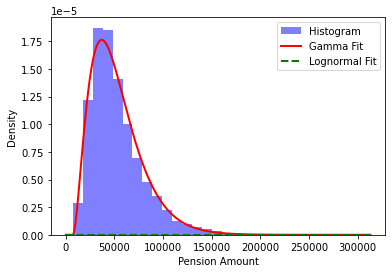

In [40]:
#https://onlinelibrary.wiley.com/doi/10.1111/j.1475-4991.2011.00478.x

#Ideally i would need real data from pension fund 
#Too hard to get data on pensions, Assumption : pension is a share of income

#Another way would be to fit a distribution from empirical data and generate from the distribution 
#could use the package scipy.stats -> fitting with MLE
import pandas as pd
import numpy as np
from scipy.stats import gamma, lognorm
import matplotlib.pyplot as plt

data_fit = pd.read_csv("/files/AP_Project/dataPensionAmount.csv")

#Fit gamma

shape, loc, scale = gamma.fit(data_fit)

print("Shape (k):", shape)
print("Location (θ):", loc)
print("Scale (β):", scale)

#Fit lognormal

sigma, mu, _ = lognorm.fit(data_fit, floc=0)

print("Standard deviation (σ):", sigma)
print("Mean (μ):", np.exp(mu))

import matplotlib.pyplot as plt

# Plot histogram
plt.hist(data_fit, bins=30, density=True, alpha=0.5, color='b', label='Histogram')

# Plot gamma distribution
x = np.linspace(0, data_fit.max(), 1000)
gamma_pdf = gamma.pdf(x, shape, loc, scale)
plt.plot(x, gamma_pdf, 'r-', lw=2, label='Gamma Fit')

# Plot lognormal distribution
lognorm_pdf = lognorm.pdf(x, sigma, 0, np.exp(mu))
plt.plot(x, lognorm_pdf, 'g--', lw=2, label='Lognormal Fit')

plt.xlabel('Pension Amount')
plt.ylabel('Density')
plt.legend()
plt.show()



#weibull_min.fit(data)
#pareto.fit(data)

#compare the function you get with histogram of the data, QQ plots and criterion like the AIC or BIC to determine the best model
#Other tests like Kolmogorov-Smirnov are easy to implement

#As mentioned in scientific litterature lognormal is often used to describe income
#If i consider that pension amount is a share of income knowing if X~lognormal
#Then alpha*X~lognormal (add parameters online)

#For male 52735 -> meanlog = 10.748, sdlog = 0.5
#For female 35422 -> meanlog = 10.35, sdlog = 0.5
#https://www.bfs.admin.ch/bfs/en/home/statistics/economic-social-situation-population/gender-equality/income/pension-gap.html#:~:text=In%202021%2C%20the%20average%20pension,this%20value%20has%20hardly%20changed.






Gamma Fit: shape = 2.877149169426519, loc = 7242.443317167007, scale = 15796.404008954363
Lognormal Fit: mu = 10.746626665046458, sigma = 0.5011452783557485


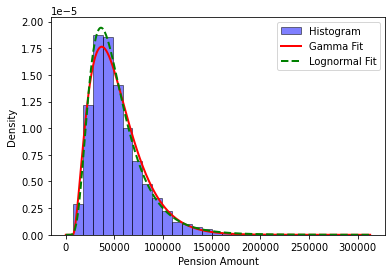

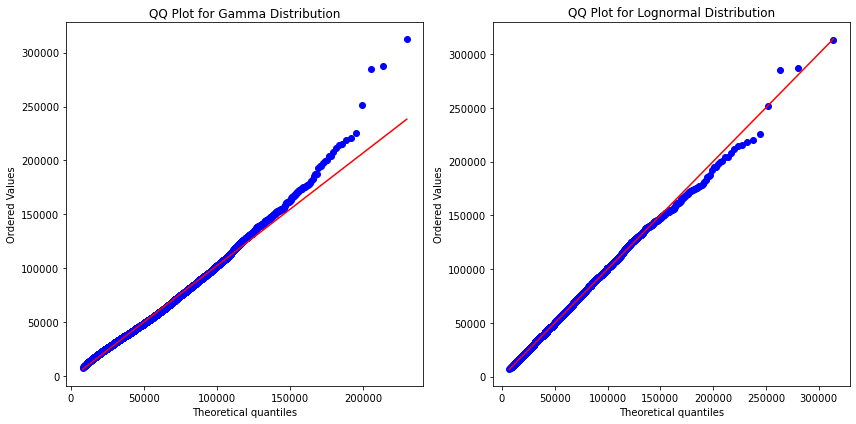

AIC for Gamma Distribution: 25544.348405434335
AIC for Lognormal Distribution: 25520.241177591062


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, lognorm, probplot
import matplotlib.pyplot as plt
import statsmodels.api as sm

data_fit = pd.read_csv("/files/AP_Project/dataPensionAmount.csv")

# Fit gamma distribution
shape_gamma, loc_gamma, scale_gamma = gamma.fit(data_fit)
print(f"Gamma Fit: shape = {shape_gamma}, loc = {loc_gamma}, scale = {scale_gamma}")

# Calculate sample mean and standard deviation
sample_mean = data_fit.mean().values[0]
sample_std = data_fit.std().values[0]

# Estimate parameters for lognormal distribution matching the moments
mu_lognorm = np.log(sample_mean**2 / np.sqrt(sample_mean**2 + sample_std**2))
sigma_lognorm = np.sqrt(np.log(1 + (sample_std**2 / sample_mean**2)))
print(f"Lognormal Fit: mu = {mu_lognorm}, sigma = {sigma_lognorm}")

# Plot histogram
plt.hist(data_fit, bins=30, density=True, alpha=0.5, color='b', edgecolor='black', label='Histogram')

# Plot gamma distribution
x_gamma = np.linspace(0, data_fit.max().values[0], 1000)
gamma_pdf = gamma.pdf(x_gamma, shape_gamma, loc_gamma, scale_gamma)
plt.plot(x_gamma, gamma_pdf, 'r-', lw=2, label='Gamma Fit')

# Plot lognormal distribution
x_lognorm = np.linspace(0, data_fit.max().values[0], 1000)
lognorm_pdf = lognorm.pdf(x_lognorm, sigma_lognorm, 0, np.exp(mu_lognorm))
plt.plot(x_lognorm, lognorm_pdf, 'g--', lw=2, label='Lognormal Fit')

plt.xlabel('Pension Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

# Generate QQ plot for gamma distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
probplot(data_fit.values.squeeze(), dist=gamma, sparams=(shape_gamma, loc_gamma, scale_gamma), plot=plt)
plt.title('QQ Plot for Gamma Distribution')

# Generate QQ plot for lognormal distribution
plt.subplot(1, 2, 2)
probplot(data_fit.values.squeeze(), dist=lognorm, sparams=(sigma_lognorm, 0, np.exp(mu_lognorm)), plot=plt)
plt.title('QQ Plot for Lognormal Distribution')

plt.tight_layout()
plt.show()

# Calculate AIC for gamma distribution
gamma_model = sm.OLS(gamma.logpdf(data_fit, shape_gamma, loc_gamma, scale_gamma), np.ones(len(data_fit)))
gamma_results = gamma_model.fit()
aic_gamma = gamma_results.aic
print(f"AIC for Gamma Distribution: {aic_gamma}")

# Calculate AIC for lognormal distribution
lognorm_model = sm.OLS(lognorm.logpdf(data_fit, sigma_lognorm, 0, np.exp(mu_lognorm)), np.ones(len(data_fit)))
lognorm_results = lognorm_model.fit()
aic_lognorm = lognorm_results.aic
print(f"AIC for Lognormal Distribution: {aic_lognorm}")

#ks ?